In [1]:
import numpy as np
import pandas as pd
import pyspark as ps
import matplotlib.pyplot as plt
import csv
import seaborn as sns
import unicodedata

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In this notebook I look at the different temporal distribution.
First look at emotion over time:

In [2]:
df = pd.read_json('reduced_tweets.json', lines=True)

In [3]:
df['published'] = pd.to_datetime(df['published'])

In [4]:
def get_time_distribution(times):
    publishing_time = times.map(lambda x: x.hour).value_counts() / times.count()
    publishing_time.sort_index(inplace=True)
    return publishing_time

In [5]:
neg = get_time_distribution(df[df.sentiment == 'NEGATIVE']['published'])
neut = get_time_distribution(df[df.sentiment == 'NEUTRAL']['published'])

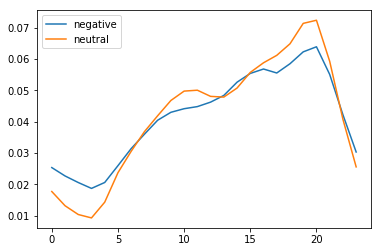

In [6]:
plt.plot(neg)
plt.plot(neut)
plt.legend(['negative', 'neutral'])
plt.show()

In [7]:
def get_yearly(times):
    publishing_time = times.map(lambda x: x.month).value_counts() / times.count()
#     publishing_time.sort_index(inplace=True)
    return publishing_time

In [8]:
total_y = get_yearly(df.published)
neg_y = get_yearly(df[df.sentiment == 'NEGATIVE']['published'])
neut_y = get_yearly(df[df.sentiment == 'NEUTRAL']['published'])

/Users/lguillain/anaconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


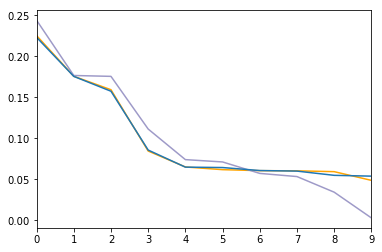

In [9]:
#the way spinner collected the tweets indicated that there is a difference in the frequency od tweets
sns.tsplot(data=total_y, color='Orange')
sns.tsplot(data=neg_y, color='Purples')
sns.tsplot(data=neut_y)
plt.show()

How the f are we supposed to deal with such an unequally distribued dataset????

In [10]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.geocode("Suisse")
## can be used to get location from name! yay!

In [11]:
location.latitude 

46.7985624

There is an issue with geolocation!
Check online dataset again

In [12]:
df.source_location.value_counts()

Switzerland                                                            989817
Suisse                                                                 334519
Schweiz                                                                238829
Genève                                                                 193084
Zürich                                                                 162622
Geneva                                                                 114273
Genève, Suisse                                                          96089
Geneva, Switzerland                                                     88079
Zurich, Switzerland                                                     80555
Zurich                                                                  73105
Lausanne                                                                60492
Bern                                                                    56698
Basel                                                           